In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import emcee

In [2]:
np.random.seed(123)

# Tutorial
https://emcee.readthedocs.io/en/stable/tutorials/line/

Use MCMC to fit a model to noisy data. The example is fitting a line when you "don't believe the error bars on your data"

In [3]:
#Define the "true" parameters for the line we will be fitting
#m is the slope and b the intercept
#with f the constant fractional amount that the uncertainties are underestimated by
m_true = -0.9594
b_true = 4.294
f_true = 0.534

## NumPy Random Generator

np.random.rand produces an array of the given shape of random samples from a uniform distribution over [0, 1)
np.random.randn produces an array of the given shape of random samples from a normal distribution with mean 0 and variance 1

In [4]:
#Generate some dummy data from the model using the parameters we just defined
N = 50
x = np.sort(10 * np.random.rand(N)) #scale the x values to lie between 0 and 10
yerr = 0.1 + (0.5 * np.random.rand(N)) #create errors for the y values that mimic random noise
y = (m_true * x) + b_true
y += np.abs(f_true * y) * np.random.randn(N)
y += yerr * np.random.randn(N)

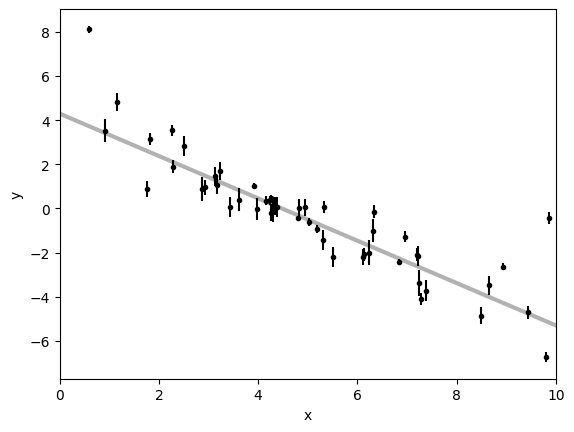

In [5]:
#Plot the dummy data and the true line
plt.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0)
x0 = np.linspace(0, 10, 500)
y0 = (m_true * x0) + b_true
plt.plot(x0, y0, 'k', alpha=0.3, lw=3)
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y');

Least-squares estimates:
m = -1.104 ± 0.016
b = 5.441 ± 0.091


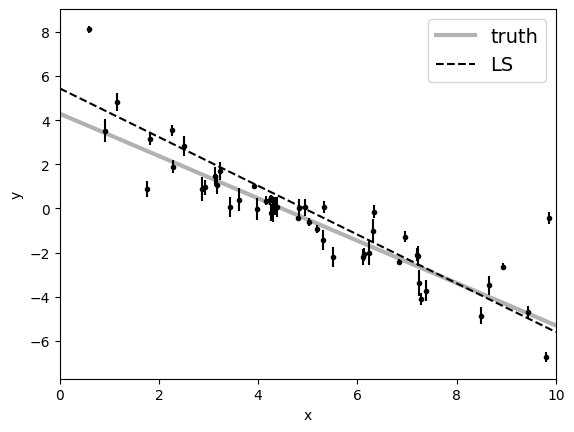

In [6]:
#It is clear that the error bars on the data are very underestimated!
#The traditional way to fit this data would be linear least squares
#Using linear least squares to fit the data above is done as follows
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x0, m_true * x0 + b_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel("x")
plt.ylabel("y");

The LS solution above is the maximum likelihood result for a model where the error bars are accurate, Gaussian, and independent. This is not the case for the data we generated, so this is not the correct model. There isn't a generalized LS approach that will work for the model we know is true, so instead we will write down the likelihood function and numerically optimize it. Code up the log likelihood as follows:

In [13]:
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = (m * x) + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    result = -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))
    return result

Note that above we used ln(f) instead of f (then exponentiated it to get the correct result). This will be important later, but also it will require f to be positive. Next we'll use scipy.optimize to find the "numerical optimum" of the likelihood function

In [14]:
#Use the Python lambda function to return the negative of the result from the log_likelihood function
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x


In [15]:
soln

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 12.18241394801541
        x: [-1.003e+00  4.528e+00 -7.904e-01]
      nit: 8
      jac: [-3.433e-05 -1.395e-05  3.695e-06]
 hess_inv: [[ 6.153e-03 -2.780e-02  6.012e-03]
            [-2.780e-02  1.287e-01 -2.748e-02]
            [ 6.012e-03 -2.748e-02  2.305e-02]]
     nfev: 202
     njev: 48

In [16]:
print('Miximum Likelihood estimates:')
print('m = {0:.3f}'.format(m_ml))
print('b = {0:.3f}'.format(b_ml))
print('f = {0:.3f}'.format(np.exp(log_f_ml)))

Miximum Likelihood estimates:
m = -1.003
b = 4.528
f = 0.454


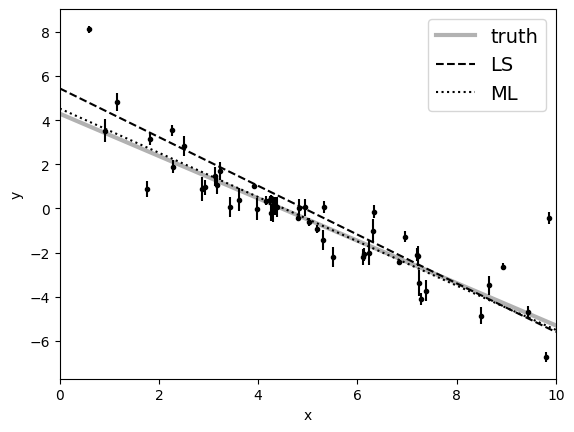

In [17]:
plt.errorbar(x, y, yerr=yerr, fmt='.k', capsize=0)
plt.plot(x0, m_true * x0 + b_true, 'k', alpha=0.3, lw=3, label='truth')
plt.plot(x0, np.dot(np.vander(x0, 2), w), '--k', label='LS')
plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ':k', label='ML')
plt.legend(fontsize=14)
plt.xlim(0, 10)
plt.xlabel('x')
plt.ylabel('y');

The module we used minimizes the function, but what we're trying to do is maximize the likelihood, which is equivalent to minimizing the negative likelihood (in this case, the negative log likelihood).

We now want to estimate the uncertainties on m and b, and propogate uncertainty on f through to them as well, which is when we will use MCMC

"It is necessary that you write down priors if you’re going to use MCMC because all that MCMC does is draw samples from a probability distribution and you want that to be a probability distribution for your parameters. This is important: you cannot draw parameter samples from your likelihood function. This is because a likelihood function is a probability distribution over datasets so, conditioned on model parameters, you can draw representative datasets (as demonstrated at the beginning of this exercise) but you cannot draw parameter samples"

For this example we'll use uniform--"uninformative"--priors on m, b and log of f:

In [19]:
def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < log_f < 1.0:
        return 0.0
    return -np.inf

In [20]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Now we can sample the distribution using emcee. Start by initializing the walkers in a very small Gaussian ball around the ML result and run 5,000 steps of MCMC.

In [22]:
pos = soln.x + (1e-4 * np.random.randn(32, 3))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:07<00:00, 680.77it/s]


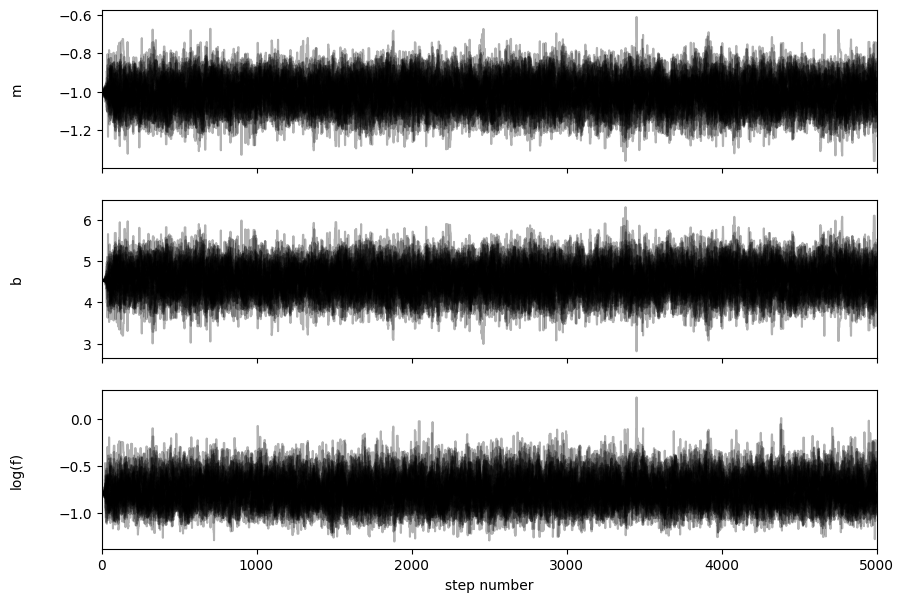

In [23]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [24]:
tau = sampler.get_autocorr_time()
print(tau)

[37.89249857 36.97192623 36.26726214]


In [25]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


In [27]:
import corner

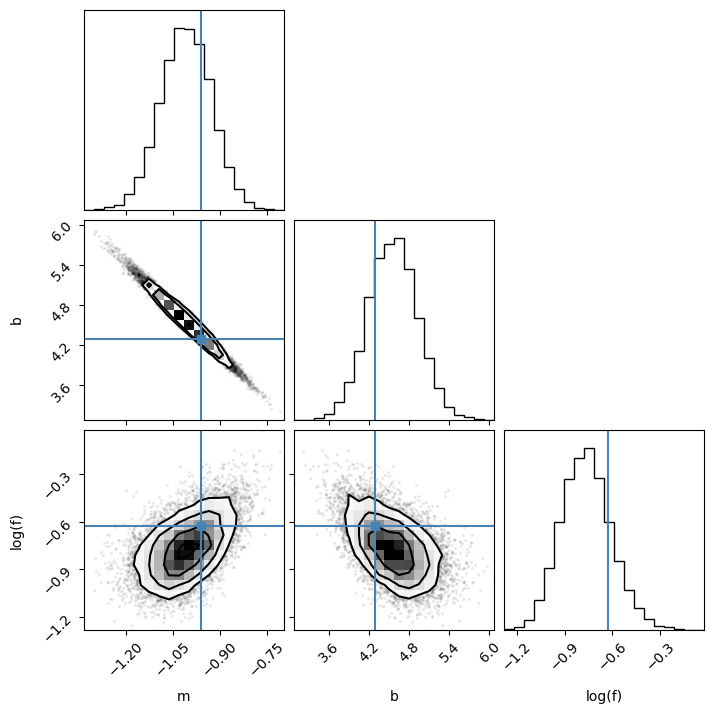

In [28]:
fig = corner.corner(
    flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)]
);